# 🛡️ Sentinel Phase 01: The Digital Gatekeeper (2-Input)

Anomaly detection starts with asking the right questions. In this first phase, we ask the system two fundamental questions about every transaction: **"How much?"** and **"How often?"**

These two data points are often enough to reveal the character of a transaction (Normal, Bot Attack, or Account Takeover).

* **Amount:** The monetary value of the transaction ($0 - $5000).
* **Frequency:** The number of transactions in the last hour ($0 - 20$).

In [7]:
!pip install scikit-fuzzy -q
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# 1. Define Universes (Input Variables)
# Amount: Transaction value from $0 to $5000
amount = ctrl.Antecedent(np.arange(0, 5001, 1), 'amount')

# Frequency: Number of transactions per hour (0 to 20)
frequency = ctrl.Antecedent(np.arange(0, 21, 1), 'frequency')

# Output Variable: Risk Score (0 = Safe, 100 = Dangerous)
risk = ctrl.Consequent(np.arange(0, 101, 1), 'risk_score')

### 🛠️ Step 1: Defining the Limits

We map real-world fraud scenarios into **Membership Functions**:

* **Small Amount ($0-$200):** Often used by bots to test if a card is valid.
* **Huge Amount ($3500+):** Often used by thieves to drain an account quickly.
* **High Frequency (15+):** Humanly impossible speed; a strong indicator of a bot attack.

We use **Trapezoidal** shapes for the edges (to capture extreme values) and **Triangular** shapes for the middle transition zones.

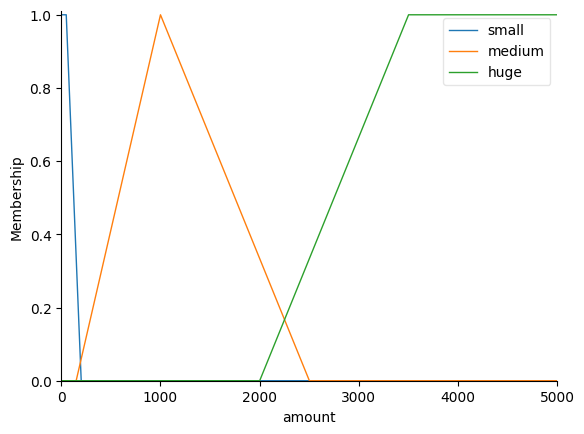

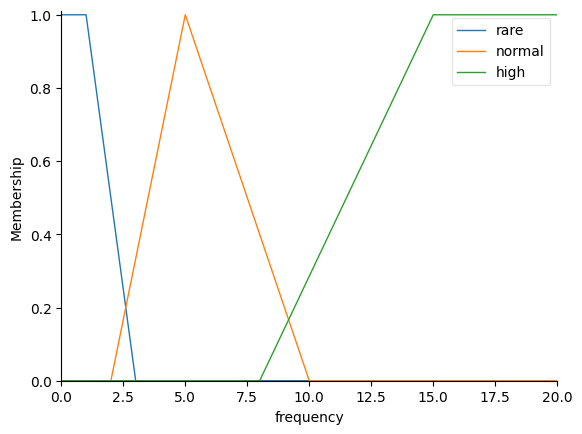

In [8]:
# 2. Define Membership Functions

# --- AMOUNT ---
amount['small'] = fuzz.trapmf(amount.universe, [0, 0, 50, 200])       # Testing the card
amount['medium'] = fuzz.trimf(amount.universe, [150, 1000, 2500])     # Normal usage
amount['huge'] = fuzz.trapmf(amount.universe, [2000, 3500, 5000, 5000]) # Account draining

# --- FREQUENCY ---
frequency['rare'] = fuzz.trapmf(frequency.universe, [0, 0, 1, 3])     # Single purchase
frequency['normal'] = fuzz.trimf(frequency.universe, [2, 5, 10])      # Active user
frequency['high'] = fuzz.trapmf(frequency.universe, [8, 15, 20, 20])  # Bot behavior

# --- RISK SCORE ---
risk['safe'] = fuzz.trapmf(risk.universe, [0, 0, 20, 40])
risk['suspicious'] = fuzz.trimf(risk.universe, [30, 50, 70])
risk['danger'] = fuzz.trapmf(risk.universe, [60, 85, 100, 100])

# Visualize to check the logic
amount.view()
frequency.view()

### 🧠 Step 2: The Sentinel's Logic

Now we teach the system how to think. We define simple rules that cover the most common fraud patterns:

1.  **Bot Pattern:** Small Amount + High Frequency = **Danger**.
2.  **Scam Pattern:** Huge Amount + Rare Frequency = **Danger**.
3.  **Standard User:** Medium Amount + Normal Frequency = **Safe**.

In [9]:
# 3. Define Rules
rule1 = ctrl.Rule(amount['small'] & frequency['high'], risk['danger'])  # Bot attack
rule2 = ctrl.Rule(amount['huge'] & frequency['rare'], risk['danger'])   # One-time big theft
rule3 = ctrl.Rule(amount['medium'] & frequency['normal'], risk['safe']) # Regular shopping

# Corner Cases (Grey Areas)
rule4 = ctrl.Rule(amount['medium'] & frequency['high'], risk['suspicious'])
rule5 = ctrl.Rule(amount['small'] & frequency['normal'], risk['suspicious'])

# Build the System
sentinel_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
sentinel = ctrl.ControlSystemSimulation(sentinel_ctrl)

### 📊 Step 3: The Risk Landscape (3D)

Finally, we visualize the decision-making process.

The **3D Surface Plot** below shows how the Sentinel reacts. You will see "Risk Peaks" (Red) where the danger is high, and "Safe Valleys" (Green) where normal transactions occur.

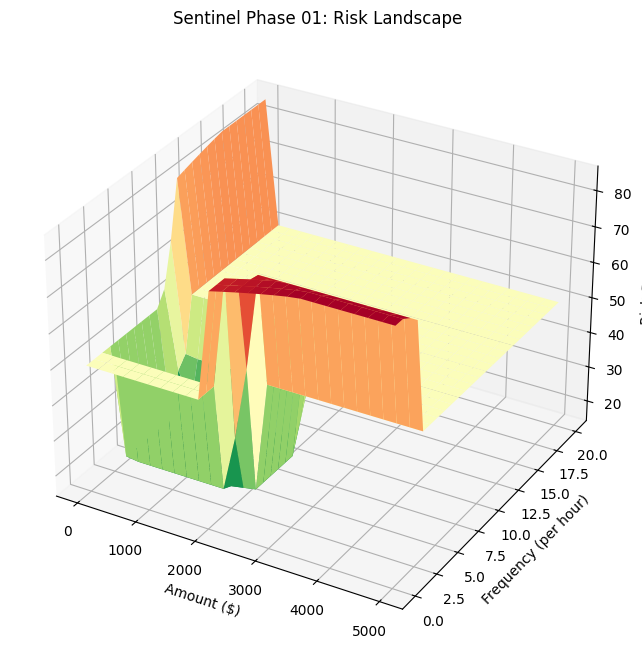

In [10]:
import matplotlib.pyplot as plt

# Define the grid
x_amt = np.linspace(0, 5000, 25)
y_frq = np.linspace(0, 20, 25)
X, Y = np.meshgrid(x_amt, y_frq)
Z = np.zeros_like(X)

# Calculate risk for every point
for i in range(25):
    for j in range(25):
        sentinel.input['amount'] = X[i, j]
        sentinel.input['frequency'] = Y[i, j]
        try:
            sentinel.compute()
            Z[i, j] = sentinel.output['risk_score']
        except:
            Z[i, j] = 50 # Default to middle if uncertain

# Plotting the 3D Surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='RdYlGn_r', edgecolor='none') # Red=Danger, Green=Safe

ax.set_title('Sentinel Phase 01: Risk Landscape')
ax.set_xlabel('Amount ($)')
ax.set_ylabel('Frequency (per hour)')
ax.set_zlabel('Risk Score')
plt.show()

### 📊 Step 3: Inside the Sentinel's Mind (3D Visualization)

Numbers are abstract, but a **Decision Surface** is concrete. The interactive chart below shows exactly how the Sentinel reacts to different scenarios.

* **Red Peaks (Danger Zone):** This is where the alarm triggers. It detects either a "Bot Attack" (High Frequency) or "Account Draining" (Huge Amount).
* **Green Valleys (Safe Zone):** The safe area where normal user behavior occurs.
* **Yellow Slopes (Suspicious):** The grey areas where the system is unsure and requests extra verification (2FA).

*Rotate the graph to see how risk escalates.*

In [11]:
import plotly.graph_objects as go

# 1. Create the Grid
x_amt = np.linspace(0, 5000, 30)  # Amount axis
y_frq = np.linspace(0, 20, 30)    # Frequency axis
X, Y = np.meshgrid(x_amt, y_frq)
Z = np.zeros_like(X)

# 2. Calculate Risk Score for every point
for i in range(30):
    for j in range(30):
        # Send values to the simulation
        sentinel.input['amount'] = X[i, j]
        sentinel.input['frequency'] = Y[i, j]
        try:
            sentinel.compute()
            Z[i, j] = sentinel.output['risk_score']
        except:
            Z[i, j] = 50 # Default to medium risk if uncertain

# 3. Plot with Plotly
fig = go.Figure(data=[go.Surface(
    z=Z, x=X, y=Y,
    colorscale='RdYlGn_r', # Green (Safe) to Red (Danger)
    opacity=0.9
)])

fig.update_layout(
    title='Sentinel Phase 01: Risk Landscape',
    scene=dict(
        xaxis_title='Amount ($)',
        yaxis_title='Frequency (per hour)',
        zaxis_title='Risk Score (%)',
        xaxis=dict(backgroundcolor="rgb(240, 240, 240)"),
        yaxis=dict(backgroundcolor="rgb(240, 240, 240)"),
        zaxis=dict(backgroundcolor="rgb(240, 240, 240)")
    ),
    width=800, height=700,
    margin=dict(l=40, r=40, b=40, t=80)
)

fig.show()

### 🎯 Result: Intelligent Anomaly Detection

This model successfully replaces rigid "If/Else" rules with a dynamic risk spectrum.

**Key Takeaway:**
Instead of blocking a user immediately, the Sentinel calculates a **Risk Score**.
* **Score < 40%:** Allow transaction silently.
* **Score 40-70%:** Trigger SMS verification (OTP).
* **Score > 70%:** Block transaction and alert the fraud team.

This approach balances **Security** with **User Experience**, ensuring that real customers are not annoyed by false alarms.